In [39]:
from PIL import Image
from tqdm.auto import tqdm
import cv2
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from timeit import default_timer as timer 
from sklearn.preprocessing import LabelEncoder

In [40]:
# Input
TRAIN_SUBSET_CSV_PATH = f"./output/df_train_subset_rsna+cddm+inbreast.csv"

# Hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 40
NUM_WORKERS = 12
LR = 0.0005
TABULAR_COLUMNS  = ["age"]

In [41]:
DF_TRAIN_SUBSET = pd.read_csv(TRAIN_SUBSET_CSV_PATH)

In [42]:
DF_TRAIN_SUBSET["view"] = LabelEncoder().fit_transform(DF_TRAIN_SUBSET["view"])
DF_TRAIN_SUBSET["laterality"] = LabelEncoder().fit_transform(DF_TRAIN_SUBSET["laterality"])

In [43]:
DF_TRAIN_SUBSET.head()

,Unnamed: 0,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,...,ID,Abnormality,Subtype,Path,Method_crop,Patient ID,Acquisition date,DG,File Name,processed_img_path
0,0,1.0,10130.0,3.888120e+08,0,4,71.0,1,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./output/RSNA+CCDM+INBREAST/10130_388811999.png
1,1,1.0,10130.0,6.134626e+08,0,1,71.0,1,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./output/RSNA+CCDM+INBREAST/10130_613462606.png
2,2,1.0,10130.0,1.360339e+09,0,1,71.0,1,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./output/RSNA+CCDM+INBREAST/10130_1360338805.png
3,3,1.0,10130.0,1.672637e+09,0,4,71.0,1,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./output/RSNA+CCDM+INBREAST/10130_1672636630.png
4,4,1.0,10226.0,4.616148e+08,0,4,71.0,1,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./output/RSNA+CCDM+INBREAST/10226_461614796.png


In [44]:
DF_TRAIN_SUBSET["age"] = DF_TRAIN_SUBSET["age"].fillna(DF_TRAIN_SUBSET["age"].mean())

In [45]:
class  MultiInputDataset(Dataset):
    
    def __init__(self, ds, tabular_columns, normalize, is_train=True):
        self.is_train = is_train
        self.ds = ds
        self.tabular_columns = tabular_columns

        self.transform = transforms.Compose([
                                            transforms.Resize((224, 224)),
                                            transforms.Grayscale(num_output_channels=3),
                                            transforms.ToTensor(),
                                            normalize
                                            ])
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):

        image_path = self.ds['processed_img_path'].iloc[idx]
        image = Image.open(image_path)
        
        image = self.transform(image)
        tabular_data = self.ds.iloc[idx, 0:]
        cancer = tabular_data["cancer"]
        tabular_data = np.array(self.ds.iloc[idx][TABULAR_COLUMNS].values, dtype=np.float32)

        return image, tabular_data, cancer

In [46]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
     
full_ds = MultiInputDataset(DF_TRAIN_SUBSET,
                            tabular_columns=TABULAR_COLUMNS,
                            normalize=normalize
                            )
train_length = round((full_ds.__len__()*80)/100)
test_length = full_ds.__len__() - train_length

train_ds, test_ds = torch.utils.data.random_split(dataset=full_ds, 
                                                lengths=[train_length, test_length], 
                                                generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_ds, 
                            batch_size=BATCH_SIZE, 
                            shuffle=True,
                            pin_memory=True)

test_dataloader = DataLoader(test_ds, 
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            pin_memory=True)

In [50]:
train_ds

In [49]:
full_ds.ds

,Unnamed: 0,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,...,ID,Abnormality,Subtype,Path,Method_crop,Patient ID,Acquisition date,DG,File Name,processed_img_path
0,0,1.0,10130.0,3.888120e+08,0,4,71.0,1,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./output/RSNA+CCDM+INBREAST/10130_388811999.png
1,1,1.0,10130.0,6.134626e+08,0,1,71.0,1,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./output/RSNA+CCDM+INBREAST/10130_613462606.png
2,2,1.0,10130.0,1.360339e+09,0,1,71.0,1,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./output/RSNA+CCDM+INBREAST/10130_1360338805.png
3,3,1.0,10130.0,1.672637e+09,0,4,71.0,1,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./output/RSNA+CCDM+INBREAST/10130_1672636630.png
4,4,1.0,10226.0,4.616148e+08,0,4,71.0,1,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./output/RSNA+CCDM+INBREAST/10226_461614796.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10653,10653,2.0,21796.0,1.545218e+09,1,4,66.0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./output/RSNA+CCDM+INBREAST/21796_1545218000.png
10654,10654,1.0,2606.0,4.778712e+08,1,4,64.0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./output/RSNA+CCDM+INBREAST/2606_477871193.png
10655,10655,2.0,40910.0,1.526917e+09,0,4,64.0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./output/RSNA+CCDM+INBREAST/40910_1526917102.png
10656,10656,1.0,55310.0,1.743227e+08,0,4,44.0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./output/RSNA+CCDM+INBREAST/55310_174322670.png


In [26]:
len(full_ds)

10658

In [27]:
item = train_ds.__getitem__(0)[0]
item

tensor([[[-2.0837, -2.0837, -2.0837,  ..., -2.0837, -2.0837, -2.0837],
         [-2.0837, -2.0837, -2.0837,  ..., -2.0837, -2.0837, -2.0837],
         [-2.0837, -2.0837, -2.0837,  ..., -2.0837, -2.0837, -2.0837],
         ...,
         [-1.9809, -1.9467, -1.9124,  ..., -2.0837, -2.0837, -2.0837],
         [-2.0665, -1.9467, -1.9980,  ..., -2.0837, -2.0837, -2.0837],
         [-2.0837, -2.0837, -2.0837,  ..., -2.0837, -2.0837, -2.0837]],

        [[-2.0007, -2.0007, -2.0007,  ..., -2.0007, -2.0007, -2.0007],
         [-2.0007, -2.0007, -2.0007,  ..., -2.0007, -2.0007, -2.0007],
         [-2.0007, -2.0007, -2.0007,  ..., -2.0007, -2.0007, -2.0007],
         ...,
         [-1.8957, -1.8606, -1.8256,  ..., -2.0007, -2.0007, -2.0007],
         [-1.9832, -1.8606, -1.9132,  ..., -2.0007, -2.0007, -2.0007],
         [-2.0007, -2.0007, -2.0007,  ..., -2.0007, -2.0007, -2.0007]],

        [[-1.7696, -1.7696, -1.7696,  ..., -1.7696, -1.7696, -1.7696],
         [-1.7696, -1.7696, -1.7696,  ..., -1

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [29]:
""" weights = models.ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights) """

""" weights = models.EfficientNet_B4_Weights.DEFAULT
model = models.efficientnet_b4(weights=weights) """

weights = models.DenseNet121_Weights.DEFAULT
model = models.densenet121(weights=weights)

In [30]:
# freeze the base layers
for param in model.parameters():
    param.requires_grad = False

In [31]:
DROPOUT_PROB = 0.1

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Densenet
IN_FEATURES = model.classifier.in_features
model.classifier = nn.Sequential(
            nn.Dropout(p=DROPOUT_PROB, inplace=True),
            nn.Linear(in_features=IN_FEATURES, out_features=2))

# Resnet
""" IN_FEATURES = model.fc.in_features
model.fc = nn.Sequential(
            nn.Dropout(p=DROPOUT_PROB, inplace=True),
            nn.Linear(in_features=IN_FEATURES, out_features=2)) """

# Efficientnet
""" IN_FEATURES = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
            nn.Dropout(p=DROPOUT_PROB, inplace=True),
            nn.Linear(in_features=IN_FEATURES, out_features=2)) """

' IN_FEATURES = model.classifier[1].in_features\nmodel.classifier[1] = nn.Sequential(\n            nn.Dropout(p=DROPOUT_PROB, inplace=True),\n            nn.Linear(in_features=IN_FEATURES, out_features=2)) '

In [32]:
class MultiInputClassifier(nn.Module):
    def __init__(self, model, use_tabular=False, output_neurons=16,  tabular_columns=len(TABULAR_COLUMNS)):
        super().__init__()
        self.use_tabular = use_tabular
        self.tabular_columns = tabular_columns
        self.output_neurons = output_neurons      
        self.pretrained = model

        self.tabular = nn.Sequential(nn.Linear(self.tabular_columns, self.output_neurons),
                                    nn.ReLU(),
                                    nn.Linear(self.output_neurons, self.output_neurons*3),
                                    nn.ReLU(),
                                    nn.Linear(self.output_neurons*3, self.output_neurons*3*3),
                                    nn.ReLU()
                                    )

        if self.use_tabular:
            self.img_plus_tab_classifier = nn.Linear(self.output_neurons*3*3+2, 2)
        else:
            self.img_classifier = nn.Linear(2, 2)

    def forward(self, img, tab):
        img = self.pretrained(img)
        tab = self.tabular(tab)

        if self.use_tabular:
            x = torch.cat((img, tab), dim=1)
            #x = nn.ReLU(x)
            x = self.img_plus_tab_classifier(x)       
        else:
            x = img
            x = self.img_classifier(x)
        return x

In [33]:
model_new = MultiInputClassifier(model, use_tabular=False)
#model_new

In [34]:
import engine

TEST_NAME = ""
loss_fn = nn.CrossEntropyLoss() # multi-class classification
optimizer = torch.optim.Adam(model_new.parameters(), lr=LR)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()
model_new = model_new.to(device)
# Setup training and save the results
results = engine.train(model=model_new,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=NUM_EPOCHS,
                device=device,
                log_txt_saver=True,
                save_model = False,
                test_name = TEST_NAME
                )

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  5%|▌         | 1/20 [01:03<20:04, 63.41s/it]

Epoch: 1 | train_loss: 0.5352 | train_acc: 0.7434 | test_loss: 0.4290 | test_acc: 0.8323


 10%|█         | 2/20 [01:55<16:56, 56.48s/it]

Epoch: 2 | train_loss: 0.4327 | train_acc: 0.8164 | test_loss: 0.4006 | test_acc: 0.8295


 15%|█▌        | 3/20 [02:38<14:20, 50.63s/it]

Epoch: 3 | train_loss: 0.4150 | train_acc: 0.8228 | test_loss: 0.3922 | test_acc: 0.8369


 20%|██        | 4/20 [03:22<12:47, 47.95s/it]

Epoch: 4 | train_loss: 0.4081 | train_acc: 0.8255 | test_loss: 0.3877 | test_acc: 0.8554


 25%|██▌       | 5/20 [04:06<11:36, 46.45s/it]

Epoch: 5 | train_loss: 0.4036 | train_acc: 0.8352 | test_loss: 0.3793 | test_acc: 0.8517


 30%|███       | 6/20 [04:58<11:17, 48.39s/it]

Epoch: 6 | train_loss: 0.3986 | train_acc: 0.8290 | test_loss: 0.3815 | test_acc: 0.8605


 35%|███▌      | 7/20 [05:48<10:36, 49.00s/it]

Epoch: 7 | train_loss: 0.3887 | train_acc: 0.8358 | test_loss: 0.3731 | test_acc: 0.8475


 40%|████      | 8/20 [06:40<10:00, 50.01s/it]

Epoch: 8 | train_loss: 0.3848 | train_acc: 0.8394 | test_loss: 0.3792 | test_acc: 0.8633


 45%|████▌     | 9/20 [07:33<09:20, 50.97s/it]

Epoch: 9 | train_loss: 0.3816 | train_acc: 0.8449 | test_loss: 0.3802 | test_acc: 0.8633


 50%|█████     | 10/20 [08:19<08:12, 49.27s/it]

Epoch: 10 | train_loss: 0.3800 | train_acc: 0.8371 | test_loss: 0.3708 | test_acc: 0.8596


 55%|█████▌    | 11/20 [09:04<07:12, 48.03s/it]

Epoch: 11 | train_loss: 0.3850 | train_acc: 0.8367 | test_loss: 0.3734 | test_acc: 0.8647


 60%|██████    | 12/20 [09:49<06:17, 47.17s/it]

Epoch: 12 | train_loss: 0.3739 | train_acc: 0.8464 | test_loss: 0.3698 | test_acc: 0.8531


 65%|██████▌   | 13/20 [10:34<05:25, 46.55s/it]

Epoch: 13 | train_loss: 0.3791 | train_acc: 0.8391 | test_loss: 0.3701 | test_acc: 0.8577


 70%|███████   | 14/20 [11:20<04:36, 46.13s/it]

Epoch: 14 | train_loss: 0.3836 | train_acc: 0.8400 | test_loss: 0.3735 | test_acc: 0.8397


 75%|███████▌  | 15/20 [12:04<03:48, 45.69s/it]

Epoch: 15 | train_loss: 0.3870 | train_acc: 0.8373 | test_loss: 0.3698 | test_acc: 0.8577


 80%|████████  | 16/20 [12:49<03:01, 45.39s/it]

Epoch: 16 | train_loss: 0.3832 | train_acc: 0.8369 | test_loss: 0.3710 | test_acc: 0.8582


 85%|████████▌ | 17/20 [13:33<02:15, 45.11s/it]

Epoch: 17 | train_loss: 0.3879 | train_acc: 0.8363 | test_loss: 0.3681 | test_acc: 0.8577


 90%|█████████ | 18/20 [14:18<01:29, 44.94s/it]

Epoch: 18 | train_loss: 0.3777 | train_acc: 0.8423 | test_loss: 0.3819 | test_acc: 0.8633


 95%|█████████▌| 19/20 [15:03<00:44, 44.82s/it]

Epoch: 19 | train_loss: 0.3739 | train_acc: 0.8447 | test_loss: 0.3696 | test_acc: 0.8494


100%|██████████| 20/20 [15:47<00:00, 47.38s/it]

Epoch: 20 | train_loss: 0.3690 | train_acc: 0.8454 | test_loss: 0.3747 | test_acc: 0.8350
[INFO] Total training time: 947.716 seconds


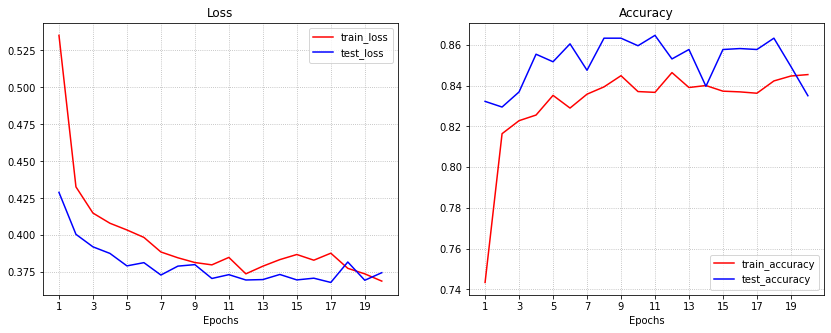

In [35]:
from util.util_plot import *

# Plot the loss curves of our model
plot_loss_accuracy_grid2_v2(results)

In [36]:
test_preds = []

model_new.to(device)
model_new.eval()

start_time_testset = timer()

with torch.inference_mode():
  for data, tab, target in tqdm(test_dataloader):
    data, tab, target = data.to(device), tab.to(device), target.to(device)
    
    test_logits = model_new(data, tab)
    pred_probs = torch.softmax(test_logits, dim=1)  # Convert the pred logits to pred probs
    pred_labels = torch.argmax(pred_probs, dim=1)  # Convert the pred probs into pred labels

    test_preds.append(pred_labels) 

end_time_testset = timer()
print(f"Total testing time: {end_time_testset-start_time_testset:.3f} (s).")

test_preds = torch.cat(test_preds).cpu()
test_truth = torch.cat([target for data, tab, target in test_dataloader])

100%|██████████| 54/54 [00:06<00:00,  7.95it/s]


Total testing time: 6.796 (s).


Main Parameters of model:Batch size: 40 
Epochs: 20 
Learning Rate: 0.0005 
Dropout Prob: 0.1 
Training time: 6.796


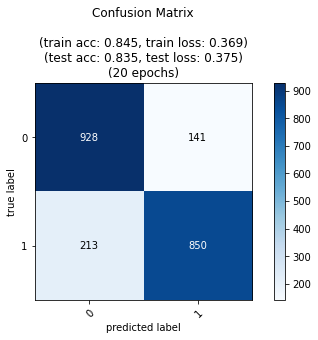

In [37]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

conf_matrix_multiclass = ConfusionMatrix(task="multiclass", num_classes=2)
conf_matrix_tensor = conf_matrix_multiclass(preds=test_preds, target=test_truth)

fig, ax = plot_confusion_matrix(
    conf_mat=conf_matrix_tensor.numpy(), 
    class_names=["0", "1"],
    figsize=(8, 4),
    colorbar=True,
    # cmap = 'magma_r'
)

last_train_acc = round(results['train_acc'][NUM_EPOCHS-1],3)
last_train_loss = round(results['train_loss'][NUM_EPOCHS-1],3)
last_test_acc = round(results['test_acc'][NUM_EPOCHS-1],3)
last_test_loss = round(results['test_loss'][NUM_EPOCHS-1],3)

ax.set_title(f"Confusion Matrix"
    +f"\n\n"+
    f"(train acc: {last_train_acc}, train loss: {last_train_loss})\n" +
    f"(test acc: {last_test_acc}, test loss: {last_test_loss})\n" +
    f"({NUM_EPOCHS} epochs)"
    )

print(f"Main Parameters of model:"+ 
      f"Batch size: {BATCH_SIZE} \n"+
      f"Epochs: {NUM_EPOCHS} \n"+
      f"Learning Rate: {LR} \n"+
      f"Dropout Prob: {DROPOUT_PROB} \n"+
      f"Training time: {end_time_testset-start_time_testset:.3f}"
      )

In [38]:
from sklearn.metrics import classification_report
print(classification_report(test_truth, test_preds))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1069
           1       0.86      0.80      0.83      1063

    accuracy                           0.83      2132
   macro avg       0.84      0.83      0.83      2132
weighted avg       0.84      0.83      0.83      2132



[0.         0.04302103 1.        ]
[0.         0.76113744 1.        ]
[2 1 0]


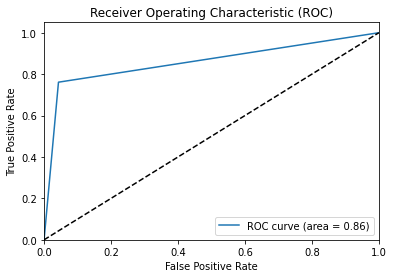

In [22]:
from sklearn.metrics import roc_curve, auc

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y,dropIntOpt):
    fpr, tpr, thresholds = roc_curve(y, pred,drop_intermediate=dropIntOpt)
    roc_auc = auc(fpr, tpr)
    print(fpr)
    print(tpr)
    print(thresholds)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

plot_roc(test_preds,test_truth,False)

## Single Image Prediction

In [23]:
simple_transform2 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), # between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
])

In [24]:
def get_laterality(img):
    img2 = img.convert('L')
    img_array = np.asarray(img2)
    img_array_T = np.transpose(img_array)
    if np.sum(img_array_T[0]) < np.sum(img_array_T[-1]):
        laterality = "R"
    else:
        laterality = "L"
    return laterality

In [25]:
def crop(img):
    img_array = np.array(img)
    bin = cv2.threshold(img_array, 20, 255, cv2.THRESH_BINARY)[1]
    
    cnts, _ = cv2.findContours(bin.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    
    mask = np.zeros(img_array.shape, np.uint8)
    cv2.drawContours(mask, [cnt], -1, 255, cv2.FILLED)

    out = cv2.bitwise_and(img_array, mask)
    x, y, w, h = cv2.boundingRect(cnt)

    cropped = out[y:y+h, x:x+w]
    mask = mask[y:y+h, x:x+w]

    return cropped, mask


In [26]:
def clahe(img, clip):
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8,8))
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl

In [27]:
def truncation_normalization(img, mask):
    mask = cv2.resize(mask, np.array(img).T.shape, interpolation = cv2.INTER_AREA)
    Pmin = np.percentile(img[mask!=0], 5)
    Pmax = np.percentile(img[mask!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[mask==0]=0
    return normalized

In [28]:
def process_image(image_path):
    img = Image.open(image_path)

    cropped, mask = crop(img)
    normalized = truncation_normalization(cropped, mask)
    cl1 = clahe(normalized, 1.0)
    cl2 = clahe(normalized, 2.0)

    processed_img = cv2.merge((np.array(normalized*255, dtype=np.uint8),cl1,cl2))
    processed_img_resized = cv2.resize(processed_img, (224, 224), interpolation = cv2.INTER_AREA)

    
    laterality = get_laterality(img) 
    if laterality == 'R':
        return cv2.flip(processed_img_resized, 1)
    else:
        return processed_img_resized

In [29]:
def pred_single_img(image_path, model, transform, class_names, device=device):
  
  prep_image = process_image(image_path)
  to_pil_img = transforms.ToPILImage()
  prep_image = to_pil_img(prep_image)
  transformed_image = transform(prep_image)
  print(transformed_image.shape)

  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device), torch.zeros(1).to(device))
    pred_prob = torch.softmax(pred_logit, dim=1)
    pred_label = torch.argmax(pred_prob, dim=1)
    pred_class = class_names[pred_label.cpu()]
  
  pred_prob_squeezed = pred_prob.unsqueeze(0).max().cpu().item()
  # plot image and pred
  plt.imshow(prep_image,'gray')
  plt.title(f"Pred: {pred_class} \n"+ 
            f"Probability: {pred_prob_squeezed:.3f} \n"+
            f"(h: {prep_image.height}, w: {prep_image.width})",
            fontsize=18)
            
  plt.axis(False); 

  print(prep_image)
  print("img width:", prep_image.width, 
          "\nimg height:", prep_image.height)
  

torch.Size([3, 224, 224])
<PIL.Image.Image image mode=RGB size=224x224 at 0x24A44C24E20>
img width: 224 
img height: 224


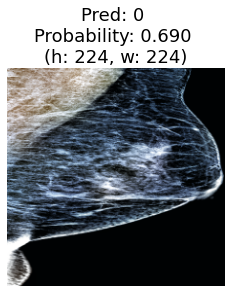

In [30]:
single_img_path_name = "./images_rsna/6018_640156723.png"

pred_single_img(image_path=single_img_path_name,
              model=model_new,
              transform=simple_transform2,
              class_names=["0", "1"])